In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input,Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

# Dataset

In [18]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [19]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [20]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1) #axis=1 is used to specify that the function should drop columns rather than rows from the DataFrame df.
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
df.columns =['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
df['b_labels'] = df['labels'].map({'ham': 0,'spam': 1})
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [23]:
Y= df['b_labels'].values
Y

array([0, 0, 1, ..., 0, 0, 0])

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(df['data'],Y,test_size=0.33)

# Preprocessing

In [25]:
# Text to sequence
MAX_VERBAL_LENGTH = 20000
tokenizer = Tokenizer(num_words=MAX_VERBAL_LENGTH)
tokenizer.fit_on_texts(X_train)
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

In [27]:
# word to integer
word2idx = tokenizer.word_index
V = len(word2idx)
V

7229

In [28]:
# Padding
data_train = pad_sequences(train_sequence)
T = len(data_train[1]) # length of a sequence
data_test = pad_sequences(test_sequence, maxlen = T)
data_train.shape, data_test.shape

((3733, 189), (1839, 189))

In [29]:
data_train

array([[   0,    0,    0, ...,  118,   65,  202],
       [   0,    0,    0, ..., 1469,   27,  329],
       [   0,    0,    0, ...,  395,   17, 3420],
       ...,
       [   0,    0,    0, ...,   45,   22,    3],
       [   0,    0,    0, ...,   11, 7228,  231],
       [   0,    0,    0, ...,    5, 7229,  881]], dtype=int32)

# Model Instantiate

In [32]:
D = 20 # number of feature
M = 15 # number of hidden neuron
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32,3,activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3,activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
r = model.fit(data_train, Y_train, validation_data=(data_test, Y_test), epochs=5)

Epoch 1/5
117/117 [==============================] - 4s 23ms/step - loss: 9.2156e-04 - accuracy: 0.9997 - val_loss: 0.0775 - val_accuracy: 0.9891
Epoch 2/5
117/117 [==============================] - 2s 21ms/step - loss: 2.5486e-04 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9848
Epoch 3/5
117/117 [==============================] - 3s 27ms/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 0.0793 - val_accuracy: 0.9908
Epoch 4/5
117/117 [==============================] - 3s 25ms/step - loss: 3.9753e-04 - accuracy: 0.9997 - val_loss: 0.0840 - val_accuracy: 0.9908
Epoch 5/5
117/117 [==============================] - 2s 20ms/step - loss: 1.1258e-04 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 0.9902


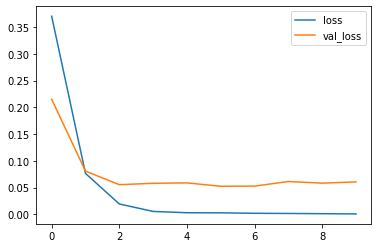

In [35]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

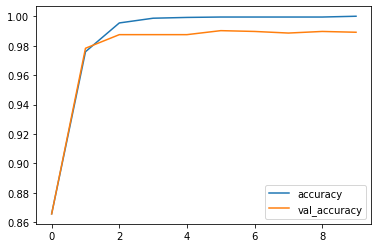

In [36]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Perfecto!

In [39]:
p_test = model.predict(data_test).argmax(axis=1)
p_test

58/58 [==============================] - 0s 5ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [41]:
# Lets print wrong prediction
misclassified_idx = np.where(p_test != Y_test)[0]
i = np.random.choice(misclassified_idx)
print('Data: %s Label: %s Prediction: %s' %(X_train[i], Y_test[i], p_test[i]))

Data: 500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY å£1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18 Label: 1 Prediction: 0


Data is spam but prediction is wrong